# WGISD Masking pipeline jupyter notebook

This notebook contains an implementation of a MaskRCNN on the custom WGSID Dataset for grape bunch segmentation as proposed by [Santos *et al.*](https://arxiv.org/pdf/1907.11819.pdf)

In [7]:
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon

from skimage.color import label2rgb

import colorsys
import random

import os

In [8]:
torch.__version__

'2.1.2'

The following example creates a `Dataset` object for the *masked* set.

In [9]:
class WGISDMaskedDataset(Dataset):
    def __init__(self, root, transforms=None, source='train'):
        self.root = root
        self.transforms = transforms
        
        # Let's load the dataset subset defined by source
        if source not in ('train', 'test'):
            print('source should by "train" or "test"')
            return None

        source_path = os.path.join(root, f'{source}_masked.txt')
        with open(source_path, 'r') as fp:
          # Read all lines in file
          lines = fp.readlines()
          # Recover the items ids, removing the \n at the end
          ids = [l.rstrip() for l in lines]

        self.imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
        self.masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
        self.boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

    def __getitem__(self, idx):
        # Load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        box_path = self.boxes[idx]

        img = Image.open(img_path).convert("RGB")

        # From TorchVision documentation:
        # 
        # The models expect a list of Tensor[C, H, W], in the range 0-1. 
        # The models internally resize the images so that they have a minimum 
        # size of 800. This option can be changed by passing the option min_size 
        # to the constructor of the models.
        
        if self.transforms is None:
            img = np.array(img)
            # Normalize
            img = (img - img.min()) / np.max([img.max() - img.min(), 1])
            # Move the channels axe to the first position, getting C, H, W instead H, W, C
            img = np.moveaxis(img, -1, 0)
            img = torch.as_tensor(img, dtype=torch.float32)  
        else:
            img = np.array(img)
            img = self.transforms(torch.as_tensor(img, dtype=torch.uint8))
            img = np.array(img)
            # Normalize
            img = (img - img.min()) / np.max([img.max() - img.min(), 1])
            # move o eixo final para frente, para termos C, H, W e não H, W, C
            img = np.moveaxis(img, -1, 0)
            img = torch.as_tensor(img, dtype=torch.float32)  

        # Loading masks:
        #
        # As seen in WGISD (README.md):
        # 
        # After assigning the NumPy array to a variable M, the mask for the 
        # i-th grape cluster can be found in M[:,:,i]. The i-th mask corresponds 
        # to the i-th line in the bounding boxes file.
        #
        # According to Mask RCNN documentation in Torchvision:
        #
        # During training, the model expects both the input tensors, as well as 
        # a targets (list of dictionary), containing:
        # (...) 
        # masks (UInt8Tensor[N, H, W]): the segmentation binary masks for each 
        # instance
        #
        # WGISD provides [H, W, N] masks, but Torchvision asks for [N, H, W]. Lett's
        # employ NumPy moveaxis.
        wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
        masks = np.moveaxis(wgisd_masks, -1, 0) 

        num_objs = masks.shape[0]
        all_text = np.loadtxt(box_path, delimiter = " ", dtype = np.float32)
        wgisd_boxes = all_text[:,1:]
        assert(wgisd_boxes.shape[0] == num_objs)

        # IMPORTANT: Torchvision considers 0 as background. So, let's make grapes
        # grapes as class 1
        labels = np.ones(num_objs, dtype=np.int64)

        # According to WGISD:
        #
        # These text files follows the "YOLO format"
        # 
        # CLASS CX CY W H
        # 
        # class is an integer defining the object class – the dataset presents 
        # only the grape class that is numbered 0, so every line starts with 
        # this "class zero" indicator. The center of the bounding box is the 
        # point (c_x, c_y), represented as float values because this format 
        # normalizes the coordinates by the image dimensions. To get the 
        # absolute position, use (2048 c_x, 1365 c_y). The bounding box 
        # dimensions are given by W and H, also normalized by the image size.
        #
        # Torchvision's Mask R-CNN expects absolute coordinates.
        _, height, width = img.shape

        boxes = []
        for box in wgisd_boxes:
            x1 = box[0] - box[2]/2
            x2 = box[0] + box[2]/2
            y1 = box[1] - box[3]/2
            y2 = box[1] + box[3]/2
            boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
        
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # max_num_boxes_in_batch = 15
        # boxes = self.pad_boxes(boxes, max_num_boxes=max_num_boxes_in_batch)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # ou poderíamos usar
        # labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id
        }

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
# Here, the WGISD root is ./
dataset = WGISDMaskedDataset('./')

In [5]:
img, target = dataset[42]
print(img.shape)

torch.Size([3, 1365, 2048])


In [6]:
for k, v in target.items():
    print(k, v.shape, v.dtype)

boxes torch.Size([10, 4]) torch.float32
labels torch.Size([10]) torch.int64
masks torch.Size([10, 1365, 2048]) torch.uint8
image_id torch.Size([1]) torch.int64


In [7]:
def random_colors(n_colors, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n_colors, 1, brightness) for i in range(n_colors)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def show_item(img, boxes, mask):

    fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2)
    # Number of instances
    n_boxes = boxes.shape[0]

    # Generate random colors
    colors = random_colors(n_boxes)

    for i, (x0, y0, x1, y1) in enumerate(boxes):
        color = np.array(colors[i])
        box_width = x1 - x0
        box_height = y1 - y0
        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax0.add_patch(p)
        ax0.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax1.add_patch(p)
        ax1.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        ax0.imshow(np.moveaxis(img, 0, -1))

    mask = np.moveaxis(mask, 0, -1)
    labels = np.zeros(mask.shape[0:2])
    for i in range(n_boxes):
        labels[mask[:,:,i] == 1] = i + 1
    
    mask_rgb = label2rgb(labels, colors=colors, bg_label=0)
    ax1.imshow(mask_rgb)

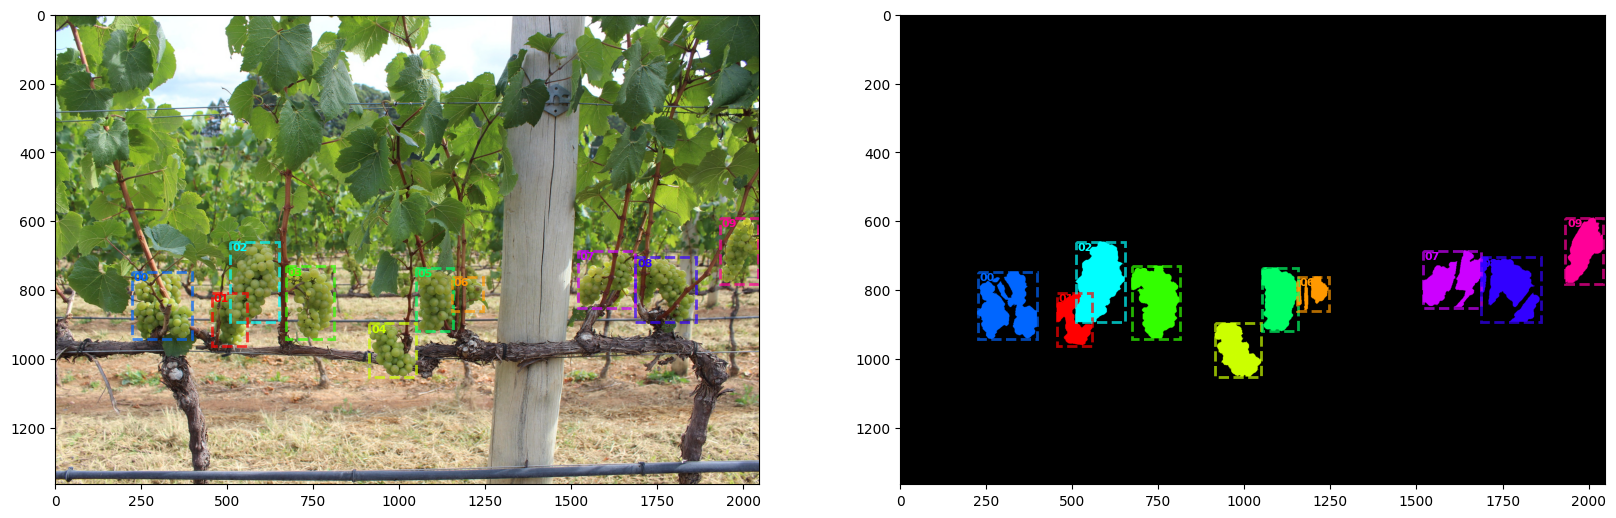

In [8]:
show_item(img.numpy(), target['boxes'].numpy(), target['masks'].numpy())

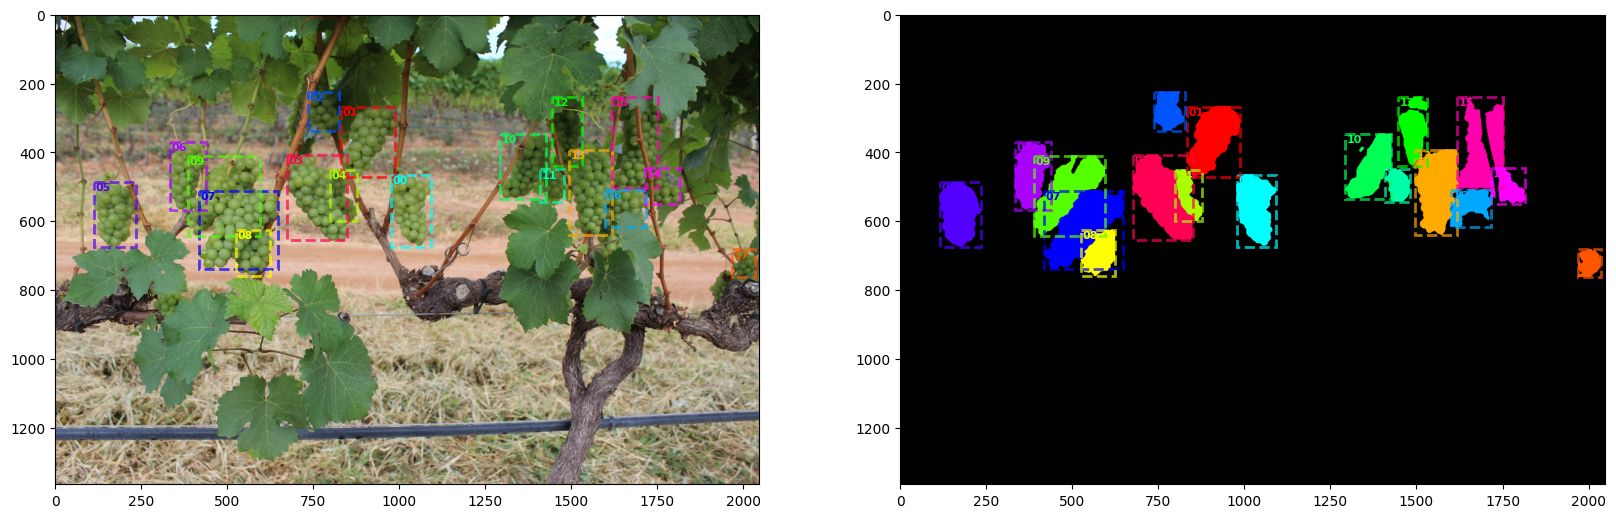

In [9]:
img, target = dataset[16]
show_item(img.numpy(), target['boxes'].numpy(), target['masks'].numpy())

# Torchvision Mask RCNN for segmentation of grape bunches

In [15]:
import os
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torch
from torchvision.transforms import transforms as T
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import faster_rcnn
from torchvision.models.detection import mask_rcnn

import matplotlib.pyplot as plt

def get_instance_segmentation_model(num_classes):
    
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    
    hidden_layer = 256
    model.roi_heads.mask_predictor = mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model


def train_one_epoch(model, optimizer, data_loader, device, tot_loss_hist, silly=False):
    epoch_loss_hist = []
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader):

        #move device if in colab
        # images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # image = images.to(device)
        # targets = [targets]
        # targets[0]['boxes'] = targets[0]['boxes'].squeeze(0)
        # targets[0]['labels'] = targets[0]['labels'].squeeze(0)

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Loss: {losses.item()}')
            
        epoch_loss_hist.append(losses.item())
        tot_loss_hist.append(losses.item())
    
    print(f'Average epoch loss: {sum(epoch_loss_hist)/len(epoch_loss_hist)}\n')
    epoch_loss_hist.clear()

def iou(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask * groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    iou = (intersect/union).item()
    return iou

def average_img_iou(preds, gts):
    ious = torch.zeros(gts.shape[0], preds.shape[0])
    for i, gt in enumerate(gts):
        for j, pr in enumerate(preds):
            current_iou = iou(gt, pr)
            ious[i, j] = current_iou

    avg_iou = ious.max(dim=1).values.mean().item()
    return avg_iou

def display_sorted_masks(image, masks):
    mask_sums = masks.view(masks.size(0), -1).sum(dim=1)
    sorted_indices = torch.argsort(mask_sums, descending=True)
    predicted_masks = masks[sorted_indices]

    num_masks = predicted_masks.shape[0] if predicted_masks.shape[0] < 6 else 6
    num_rows = (num_masks - 1) // 3 + 1
    num_cols = min(num_masks, 3)

    plt.figure(figsize=(15, 10))

    for i in range(num_masks):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.imshow(predicted_masks[i].permute(1, 2, 0).cpu().numpy(), alpha=0.5)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    best_mask = predicted_masks[0]
    return best_mask

def sort_masks_by_sum(masks):
    mask_sums = masks.view(masks.size(0), -1).sum(dim=1)
    sorted_indices = torch.argsort(mask_sums, descending=True)
    predicted_masks = masks[sorted_indices]
    return predicted_masks
    


# Define the dataset
dataset = WGISDMaskedDataset('./')

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

train_dataset = torch.utils.data.Subset(dataset, indices[:100])
test_dataset = torch.utils.data.Subset(dataset, indices[100:110])

def collate_fn(batch):
    return tuple(zip(*batch))  

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=True, collate_fn=collate_fn)
print(f'Train set of size {train_dataset.__len__()} loaded')
print(f'Test set of size {test_dataset.__len__()} loaded')

num_classes = 2  #grape and background
model = get_instance_segmentation_model(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-3)

Train set of size 100 loaded
Test set of size 10 loaded


Run training for Num_epochs..

In [ ]:
loss_history = []
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, loss_history)

print(f'Trained {num_epochs} epochs..')

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Save model after training..

In [ ]:
torch.save(model.state_dict(), 'wgisd_v1.6.pth')

Load model for inference

In [16]:
grape_model = get_instance_segmentation_model(num_classes)
grape_model.load_state_dict(torch.load('wgisd_v1.5.pth'))
grape_model.eval()

print('model set to eval!')

model set to eval!


Run an example result

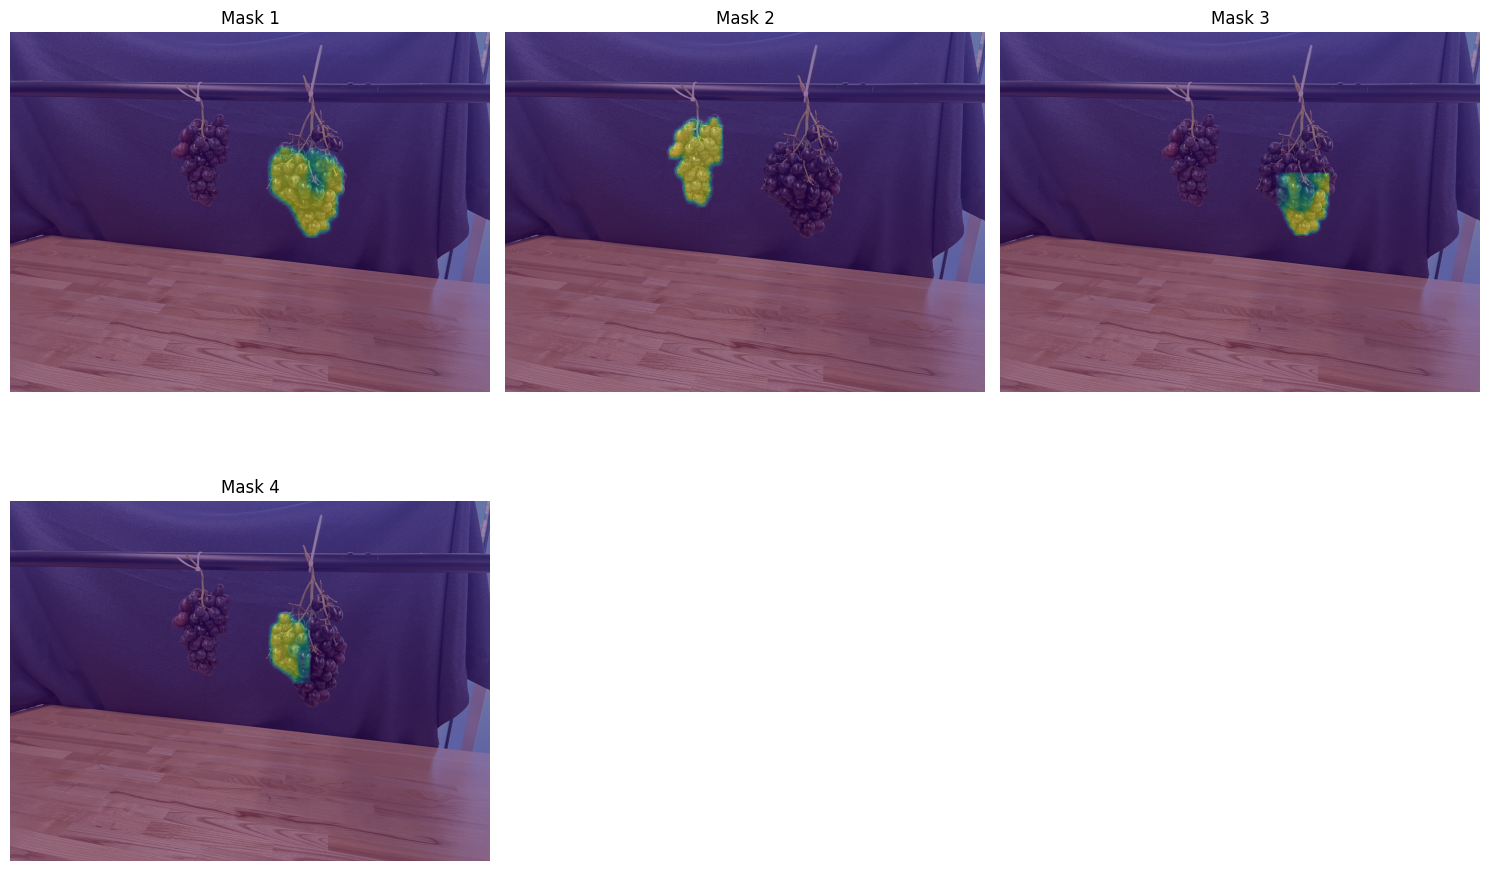

bbox shape: torch.Size([4, 4])
masks shape: torch.Size([4, 1, 3024, 4032])


In [41]:
import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image
import matplotlib.pyplot as plt

test = Image.open('lab4.JPG')
test_tensor = to_tensor(test).unsqueeze(0)

with torch.no_grad():
    prediction = grape_model(test_tensor)
    prediction = prediction.pop()

predicted_boxes = prediction['boxes']
predicted_masks = prediction['masks']

best_mask = display_sorted_masks(test, predicted_masks)

print(f'bbox shape: {predicted_boxes.shape}')
print(f'masks shape: {predicted_masks.shape}')

Run evaluation to calculate average test set iou

In [42]:
#Evaluate model
test_set = WGISDMaskedDataset('./', source='test')
test_loader = DataLoader(test_set, batch_size=1)

avg_ious = []
for i, (image, target) in enumerate(test_loader):
    out = grape_model(image).pop()
    pred_masks = out['masks']
    #get from npz file directly, targets not working properly
    gt_masks = to_tensor(np.load(test_set.masks[i])['arr_0']).unsqueeze(1)
    avg_iou = average_img_iou(pred_masks, gt_masks)
    avg_ious.append(avg_iou)

print(f'Test set avg iou: {sum(avg_ious)*100/len(avg_ious)} %')

Test set avg iou: 71.37046721246507 %


# Testing 3D point cloud reconstruction

Load DepthAnything for monocular depth map estimation

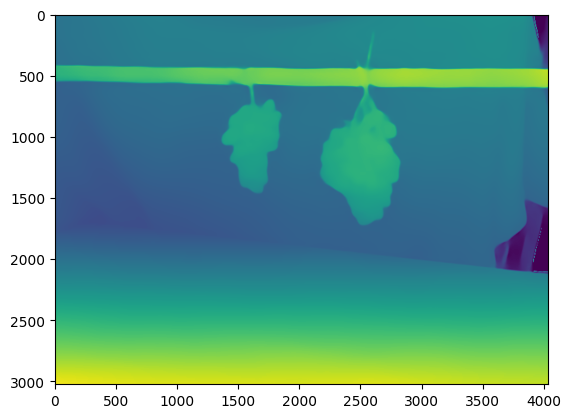

In [43]:
from transformers import pipeline

# load pipe
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

# load image
image = Image.open('lab4.JPG')

# inference
out = pipe(image)
depth_map = out['predicted_depth']
depth_img = out['depth']

plt.imshow(depth_img)
plt.show()

"best_mask" from the example cell contains the mask of the biggest mask. For grapes_test.jpeg, that is the prominent one in the center. We will use this to build our 3D reconstruction pipeline.

In [44]:
print('Center grape bunch mask: ',best_mask.shape)

Center grape bunch mask:  torch.Size([1, 3024, 4032])


Camera matrix

In [50]:
fx = 18
fy = 18
cx = best_mask.shape[0] / 2
cy = best_mask.shape[1] / 2

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
K_inv = np.linalg.inv(K)

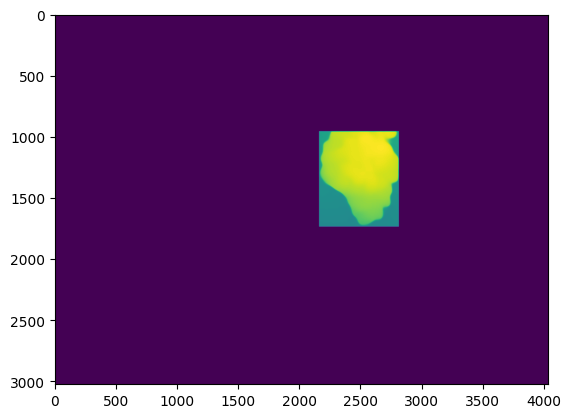

In [51]:
import numpy as np

grape_mask = best_mask.squeeze(0)
depth_tensor = to_tensor(depth_img).squeeze(0) * grape_mask / (grape_mask+1e-19)

plt.imshow(depth_tensor.numpy())
plt.show()

In [52]:
def point_cloud_reconstruction(depth_tensor, K_inv, sparse_point_cloud=False, sparse_points=2000):
    points = []
    for y, row in enumerate(depth_tensor):
        for x, val in enumerate(row):
            if val != 0:
                
                point_pixel = np.array([x, y, 1])
                point_camera = np.matmul(K_inv, point_pixel)
                depth_value = depth_tensor[y, x]
                if depth_value < 0.2 or depth_value > 0.95:
                    continue

                
                point_camera[2] = depth_value
                points.append(point_camera)

    points = np.array(points)
    
    if not sparse_point_cloud:
        print(f'Constructed {len(points)} 3d points from mask and depth')
        return points
    else:
        sample_indices = np.random.choice(len(points), size=sparse_points, replace=False)
        points = points[sample_indices]
        print(f'Constructed {len(points)} 3d points from mask and depth')
        return points

In [53]:
# depth_tensor = torch.flip(depth_tensor, dims=[1])

points = point_cloud_reconstruction(depth_tensor, K_inv, sparse_point_cloud=False, sparse_points=8500)

Constructed 507908 3d points from mask and depth


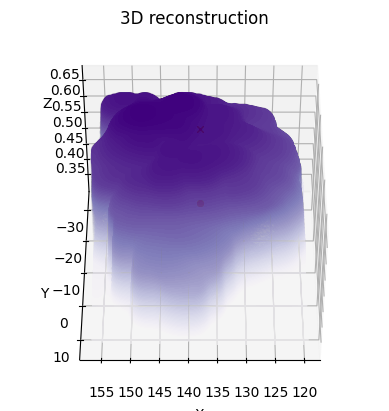

Bunch center: [138.05555555555557, -9.166666666666666, 0.5280601107063988]
Estimated cutting point from bunch center: [138.05555555555557, -32.77777777777778, 0.5280601107063988]


In [54]:
#Visualize point cloud plot
import matplotlib.pyplot as plt

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

mean_point = [np.mean(x), np.mean(y), np.mean(z)]
estimated_cutting_from_bunch_center = [mean_point[0], np.min(y) - 2, mean_point[2]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=z, cmap='Purples', alpha=0.04, s=30) # grape point cloud
ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='red', marker='o') # bunch center
ax.scatter(mean_point[0], np.min(y) - 2, mean_point[2], c='red', marker='x', s=25) #estimated cutting point


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D reconstruction')
ax.view_init(elev=45, azim=90, roll=0)
ax.autoscale_view()

plt.show()

print(f'Bunch center: {mean_point}')
print(f'Estimated cutting point from bunch center: {estimated_cutting_from_bunch_center}')

# Cylinder fitting

In [157]:
import numpy as np

def get_bbox_edges(points):
    # Calculate the bounding box dimensions
    xmax, xmin = np.max(points[:, 0]), np.min(points[:, 0])
    ymax, ymin = np.max(points[:, 1]), np.min(points[:, 1])
    zmax, zmin = np.max(points[:, 2]), np.min(points[:, 2])
    
    bbox_vertices = np.array([[xmin, ymin, zmin],
                              [xmax, ymin, zmin],
                              [xmin, ymax, zmin],
                              [xmin, ymin, zmax],
                              [xmax, ymax, zmin],
                              [xmax, ymax, zmax],
                              [xmax, ymin, zmax],
                              [xmin, ymax, zmax]])
    
    bbox_edges = [
        (bbox_vertices[0], bbox_vertices[1]),
        (bbox_vertices[0], bbox_vertices[2]),
        (bbox_vertices[0], bbox_vertices[3]),

        (bbox_vertices[1], bbox_vertices[4]),
        (bbox_vertices[1], bbox_vertices[6]),

        (bbox_vertices[2], bbox_vertices[4]),
        (bbox_vertices[2], bbox_vertices[7]),

        (bbox_vertices[3], bbox_vertices[6]),
        (bbox_vertices[3], bbox_vertices[7]),

        (bbox_vertices[4], bbox_vertices[5]),

        (bbox_vertices[5], bbox_vertices[6]),
        (bbox_vertices[5], bbox_vertices[7]),

    ]
    
    return bbox_vertices, bbox_edges

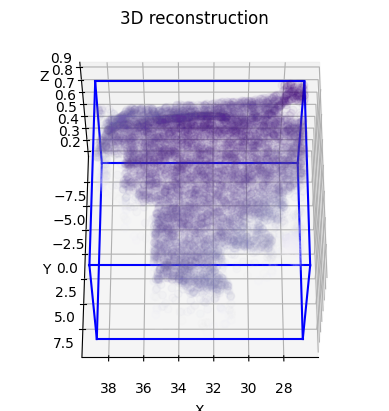

Bunch center: [32.41520588235294, -1.940908088235294, 0.704515817847322]
Estimated cutting point from bunch center: [32.41520588235294, -10.9375, 0.704515817847322]


In [161]:
#Visualize point cloud plot
import matplotlib.pyplot as plt

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

mean_point = [np.mean(x), np.mean(y), np.mean(z)]
estimated_cutting_from_bunch_center = [mean_point[0], np.min(y) - 2, mean_point[2]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=z, cmap='Purples', alpha=0.04, s=30) # grape point cloud
# ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='red', marker='o') # bunch center
# ax.scatter(mean_point[0], np.min(y) - 2, mean_point[2], c='red', marker='x', s=25) #estimated cutting point

bbox_vertices, bbox_edges = get_bbox_edges(points)

for edge in bbox_edges:
    x, y, z = zip(*edge)
    ax.plot(x, y, z, color='b')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D reconstruction')
ax.view_init(elev=60, azim=90, roll=0)
ax.autoscale_view()

plt.show()

print(f'Bunch center: {mean_point}')
print(f'Estimated cutting point from bunch center: {estimated_cutting_from_bunch_center}')

# End of WGISD Masking notebook